In [1]:
#imports các thư viện
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

In [2]:
def create_lagged_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    columns, names = list(), list()

    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]

    #put it all together
    final = concat(columns, axis=1)
    final.columns = names

    #loại bỏ các dòng có giá trị NaN
    final.dropna(inplace=True)

    return final


In [3]:
def rsi(data, period: int = 14):

    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))


In [4]:
#lag granularity (độ trễ) - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"


In [5]:
#read dataset
folder = "./../../datasets/tweets_prices_volumes_sentiment/" + \
    analyser+"/"+dataset_grouped_by+"_datasets/cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_" + \
    str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)


In [6]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())
df


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_2860\3584252857.py:2: FutureWarning: ['dt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby('DateTime').agg(lambda x: x.mean())


,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,Tweet_vol
DateTime,,,,,,,,
2018-08-30 00:00:00+00:00,7027.99,5.484323,6979.227679,0.043827,0.825543,0.130654,0.230801,557.0
2018-08-31 00:00:00+00:00,7187.23,3.694477,7097.021073,0.039833,0.847201,0.112971,0.196773,902.0
2018-09-01 00:00:00+00:00,7275.00,2.830380,7233.487967,0.036618,0.846208,0.117174,0.208065,818.0
2018-09-02 00:00:00+00:00,7301.01,2.130486,7260.380171,0.047145,0.837654,0.115190,0.163561,860.0
2018-09-03 00:00:00+00:00,7357.07,3.392408,7317.186602,0.045408,0.839805,0.114770,0.181093,980.0
...,...,...,...,...,...,...,...,...
2019-11-19 00:00:00+00:00,8085.36,2.133512,8098.781070,0.066980,0.751580,0.181439,0.269207,62924.0
2019-11-20 00:00:00+00:00,7618.17,7.593120,7834.680432,0.060034,0.744159,0.195808,0.297821,61536.0
2019-11-21 00:00:00+00:00,7272.99,16.570352,7301.606288,0.071387,0.744532,0.184078,0.250644,69663.0


In [7]:
#tính toán các chỉ số indicator: rsi, ma
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()

if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()

if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]


In [8]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity', 'Tweet_vol', 'Volume_(BTC)'] if analyser == "Textblob" else [
    'Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")

if(add_longMAvg):
    features.append("long_mavg")

if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]


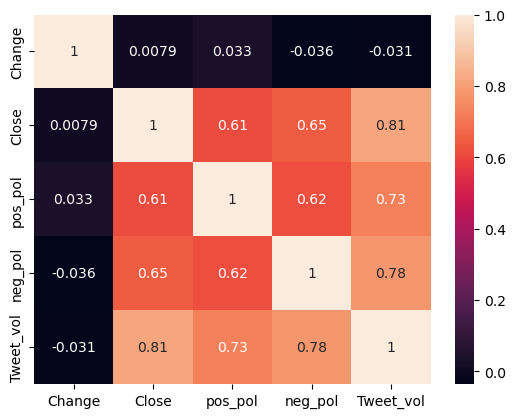

In [9]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()


In [10]:
#creating copy so that data is not loaded once again
df_copy = df.copy()


In [11]:
#number of previous records to consider for every example
n_lag = 7
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features


In [12]:
#add lagged data to records
data_with_lagged = create_lagged_features(df_copy, n_lag, 1)
data_with_lagged = data_with_lagged.reset_index()
data_with_lagged = data_with_lagged.drop(['DateTime'], axis=1)


In [13]:
#shuffle data
np.random.seed(1)
#shuffle times
shuffle_times = 3
for j in range(0, shuffle_times+1):
    data_with_lagged = shuffle(data_with_lagged)


In [14]:
#divide df into train and test
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)

train = data_with_lagged.iloc[:train_size]
test = data_with_lagged.iloc[train_size:]


In [15]:
#prepare labels
train_y = train["var1(t)"].values
test_y = test["var1(t)"].values

train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)


In [16]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)


In [17]:
#prepare data
train_labels = train_y
test_labels = test_y


In [18]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]


In [19]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]


In [20]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))


In [21]:
#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 2)


In [22]:
np.random.seed(1)
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 32
epochs = 10000
dropout = 0.25
batch_size = 80
activ_func = "linear"

model.add(LSTM(neurons, return_sequences=False, input_shape=(
    train_X.shape[1], train_X.shape[2]), activation=activ_func))
model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [23]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
# early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =20)

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True,validation_split=0.2, callbacks=[callback])

Epoch 1/10000


4/4 - 2s - loss: 0.7071 - accuracy: 0.4884 - val_loss: 0.6767 - val_accuracy: 0.6447 - 2s/epoch - 619ms/step
Epoch 2/10000
4/4 - 0s - loss: 0.6984 - accuracy: 0.4684 - val_loss: 0.6852 - val_accuracy: 0.6447 - 51ms/epoch - 13ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6954 - accuracy: 0.4950 - val_loss: 0.6958 - val_accuracy: 0.4342 - 49ms/epoch - 12ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6957 - accuracy: 0.4950 - val_loss: 0.6986 - val_accuracy: 0.3684 - 46ms/epoch - 12ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6949 - accuracy: 0.5150 - val_loss: 0.7021 - val_accuracy: 0.3816 - 49ms/epoch - 12ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6955 - accuracy: 0.5183 - val_loss: 0.7029 - val_accuracy: 0.3684 - 107ms/epoch - 27ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.6879 - accuracy: 0.5282 - val_loss: 0.7030 - val_accuracy: 0.3684 - 76ms/epoch - 19ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.6921 - accuracy: 0.5050 - val_loss: 0.6989 - val_accuracy: 0.4079 - 65ms/epoch - 16ms/step
Epoch 9/10000
4/4 - 0s

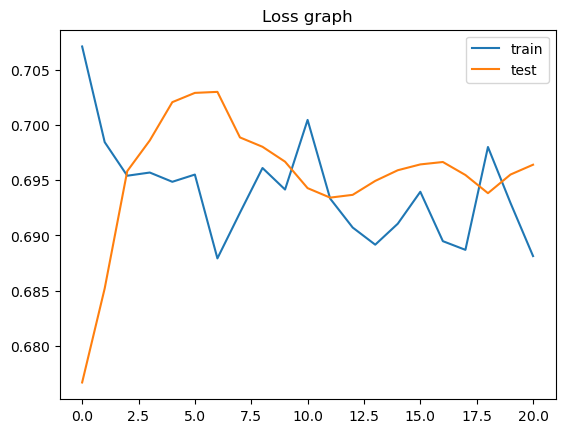

In [25]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

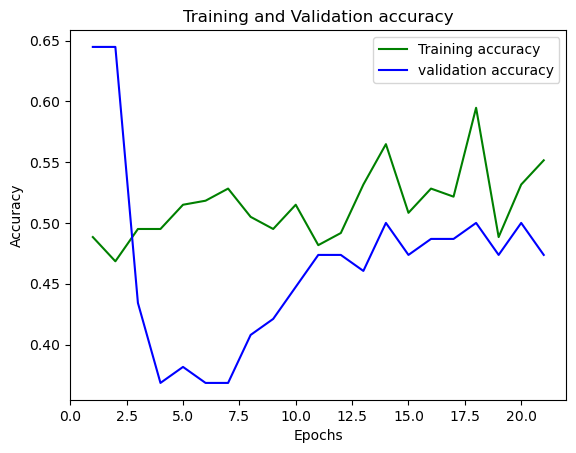

In [26]:
#plot training and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1, len(loss_val) + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [27]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

3/3 [==============================] - 0s 3ms/step


In [28]:
#change back from categorical
pred = np.argmax(pred, axis=1)


In [29]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.6417910447761194
